# CHAPTER 5: _Measuring Group Fairness_

## The Preparations

### Installing the Libraries

In [1]:
%%capture
!pip install aequitas
!pip install solas-ai
!pip install 'aif360[inFairness]'
!pip install 'aif360[OptimalTransport]'

### Loading the Libraries

In [2]:
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn import metrics as sklearn_metrics
from aif360.sklearn import metrics as aif_metrics

from scipy.stats import ttest_ind
from scipy.stats import describe

from statsmodels.api import Logit
from statsmodels.api import OLS

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

import aequitas.plot as ap

import solas_disparity as sd

/usr/local/lib/python3.10/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.10/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted

## Importing and Preparing the Data

In [3]:
url = 'https://raw.githubusercontent.com/PacktPublishing/Building-Responsible-AI-with-Python/main/data/hmda.csv'
df = pd.read_csv(url, index_col=0)

label = 'low_priced'
features = [
    'loan_amount', 'loan_to_value_ratio', 'no_intro_rate_period', 'intro_rate_period',
    'property_value', 'income', 'debt_to_income_ratio', 'term_360', 'conforming',
    'state_target_encoded', 'product_type_conventional', 'product_type_fha',
    'product_type_fsa_rhs', 'product_type_va'
]

Below, we will split the data into a training set and a validation set using the `train` variable.  In this example, we use a relatively simple XGBoost gradient boosting machine algorithm to predict whether loans will be `low_priced`.  After building the model, we calculate predicted probabilities on the training and validation sets and then calculate the ROC-AUC statistics.  We see that the training and validation AUC values are quite high - over 0.90.  The percentage drop in the validation AUC relative to the training AUC is about 1.6%, small enough to indicate that the model is likely not overfitting the data.

In [4]:
train = df.loc[df['train'] == 'train', :].copy()
valid = df.loc[df['train'] != 'train', :].copy()
print(f"Number of Observations: Training: {train.shape[0]:,.0f}; Validation: {valid.shape[0]:,.0f}")

Number of Observations: Training: 240,510; Validation: 59,490


In [5]:
params = {
    'n_estimators': 100,
    'eval_metric': 'auc',
    'random_state': 31415,
}

xgb_model = xgb.XGBClassifier(**params).fit(X=train[features], y=train[label])
train['predictions'] = xgb_model.predict_proba(X=train[features])[:, 1]
valid['predictions'] = xgb_model.predict_proba(X=valid[features])[:, 1]

In [6]:
xgb_auc_train = sklearn_metrics.roc_auc_score(y_true=train[label], y_score=train['predictions'])
xgb_auc_valid = sklearn_metrics.roc_auc_score(y_true=valid[label], y_score=valid['predictions'])
print(
    f"\nTraining and Validation Set AUCs: {xgb_auc_train: 0.4f}, {xgb_auc_valid: 0.4f}"
    f"\nPercent Drop in AUC: Training to Validation: {xgb_auc_valid / xgb_auc_train -1:0.3%}"
)


Training and Validation Set AUCs:  0.9325,  0.9159
Percent Drop in AUC: Training to Validation: -1.786%


In [7]:
def offer_function(
        data: pd.DataFrame,
        probability_cutoff_1 = 0.65,
        dti_cutoff = 0.4,
        probability_cutoff_2 = 0.90,
):

    offer_type1 = (data['predictions'] >= probability_cutoff_1) & \
                  (data['debt_to_income_ratio'] <= dti_cutoff)

    offer_type2 = (data['predictions'] >= probability_cutoff_2)

    offer = (offer_type1 | offer_type2).astype(int)

    return offer

valid['Low Priced Offer'] = offer_function(data=valid)

### Measuring continuous outcomes of group fairness

#### Marginal Effect

In [8]:
valid_known_race = valid.loc[(valid['race'] != 'Unknown'), :].copy()
score_summary = valid_known_race.groupby(by='race')['predictions'].agg(['count', 'mean'])
score_summary.columns = ['Observations', 'Average Score']

prot_race_mask = (score_summary.index != 'White')

ref_average = score_summary.loc[~prot_race_mask, 'Average Score'].values
score_summary.loc[prot_race_mask, 'Marginal Effect'] = score_summary.loc[prot_race_mask, 'Average Score'] - ref_average
format_dict = {
    'Observations': '{:,.0f}',
    'Average Score': '{:.1%}',
    'Marginal Effect': '{:.1%}'
}

score_summary.style.format(format_dict, na_rep='-')

,Observations,Average Score,Marginal Effect
race,,,
Asian,"4,014",94.4%,3.7%
Black,"3,999",82.3%,-8.4%
Hawaiian or pacific islander,141,89.2%,-1.5%
Native american,227,85.4%,-5.3%
White,"42,788",90.7%,-


#### Determining statistical significance of continuous outcomes

In [9]:
for race_i in [x for x in valid_known_race['race'].unique() if x != 'White']:
    t, p = ttest_ind(
        a=valid_known_race.loc[valid['race'] == race_i, 'predictions'],
        b=valid_known_race.loc[valid['white'] == 1, 'predictions'],
        equal_var=True,
        alternative='two-sided'
    )
    score_summary.loc[race_i, ['T-Statistic', 'P-Value']] = t, p

format_dict = {
    'Observations': '{:0,.0f}',
    'Average Score': '{:0.1%}',
    'Marginal Effect': '{:0.2%}',
    'T-Statistic': '{:0.2f}',
    'P-Value': '{:0.1%}',
}

score_summary.style.format(format_dict, na_rep='-')

,Observations,Average Score,Marginal Effect,T-Statistic,P-Value
race,,,,,
Asian,"4,014",94.4%,3.75%,13.54,0.0%
Black,"3,999",82.3%,-8.35%,-29.18,0.0%
Hawaiian or pacific islander,141,89.2%,-1.46%,-1.02,30.6%
Native american,227,85.4%,-5.28%,-4.69,0.0%
White,"42,788",90.7%,-,-,-


In [10]:
score_reg_data = pd.get_dummies(data=valid_known_race[['race', 'predictions']], columns=['race'])
score_reg_data.columns = [x[5:] if x.startswith('race_') else x for x in score_reg_data.columns]
score_reg_data['intercept'] = 1
score_reg_data.drop(columns='White', inplace=True)

In [11]:
score_reg_fit = OLS(
  endog=score_reg_data['predictions'],
  exog=score_reg_data.drop(columns=['predictions'])).fit()

table_01 = score_reg_fit.summary().tables[1].data
table_01 = pd.DataFrame(data=table_01[1:], columns=table_01[0])

table_01 = table_01.set_index(keys='').drop(columns=['[0.025', '0.975]'])
table_01

,coef,std err,t,P>|t|
,,,,
Asian,0.0375,0.003,13.208,0.000
Black,-0.0835,0.003,-29.390,0.000
Hawaiian or pacific islander,-0.0146,0.014,-1.007,0.314
Native american,-0.0528,0.011,-4.617,0.000
intercept,0.9069,0.001,1091.520,0.000


#### Determining the practical significance of continuous outcomes

In [12]:
score_std_dev = valid['predictions'].std()
score_summary['SMD'] = score_summary['Marginal Effect'] / score_std_dev
score_summary['Significant'] = ''
score_summary.loc[(score_summary['P-Value'] < 0.05) & (score_summary['SMD'] < -0.3), 'Significant'] = "Yes"
format_dict = {
    'Observations': '{:0,.0f}',
    'Average Score': '{:0.1%}',
    'Marginal Effect': '{:0.2%}',
    'T-Statistic': '{:0.2f}',
    'P-Value': '{:0.1%}',
    'SMD': '{:0.3f}'
}
score_summary.style.format(format_dict, na_rep='-')

,Observations,Average Score,Marginal Effect,T-Statistic,P-Value,SMD,Significant
race,,,,,,,
Asian,"4,014",94.4%,3.75%,13.54,0.0%,0.216,
Black,"3,999",82.3%,-8.35%,-29.18,0.0%,-0.482,Yes
Hawaiian or pacific islander,141,89.2%,-1.46%,-1.02,30.6%,-0.084,
Native american,227,85.4%,-5.28%,-4.69,0.0%,-0.305,Yes
White,"42,788",90.7%,-,-,-,-,


#### Measuring categorical outcomes of group fairness

In [13]:
offer_summary =  valid_known_race.groupby(by='race')['Low Priced Offer'].agg(['count', 'sum', 'mean'])
offer_summary.columns = ['Observations', 'Offers', 'Percent Offer']

format_dict = {
    'Observations': '{:0,.0f}',
    'Offers': '{:0,.0f}',
    'Percent Offer': '{:0.2%}',
}
offer_summary.style.format(format_dict)

,Observations,Offers,Percent Offer
race,,,
Asian,"4,014","3,656",91.08%
Black,"3,999","2,507",62.69%
Hawaiian or pacific islander,141,108,76.60%
Native american,227,166,73.13%
White,"42,788","35,329",82.57%


In [14]:
score_reg_data['Low Priced Offer'] = valid['Low Priced Offer']
offer_logit_fit = Logit(endog=score_reg_data['Low Priced Offer'], exog=score_reg_data.drop(columns=['predictions', 'Low Priced Offer'])).fit()

Optimization terminated successfully.
         Current function value: 0.466188
         Iterations 6


In [15]:
reference_pct = offer_summary.at['White', 'Percent Offer']

prot_race_mask_offer = (offer_summary.index != 'White')

offer_summary['Marginal Effect'] = offer_summary.loc[prot_race_mask_offer, 'Percent Offer'] - reference_pct
offer_summary['AIR'] = offer_summary.loc[prot_race_mask_offer, 'Percent Offer'] / reference_pct

offer_summary['Odds'] = offer_summary['Percent Offer'] / (1 - offer_summary['Percent Offer'])
reference_odds = offer_summary.at['White', 'Odds']
offer_summary['Odds Ratio'] = offer_summary.loc[prot_race_mask_offer, 'Odds'] / reference_odds

offer_summary['Z-Statistic'] = offer_logit_fit.tvalues[prot_race_mask_offer]
offer_summary['P-Value'] = offer_logit_fit.pvalues[prot_race_mask_offer]

format_dict = {keys: '{:0.1%}' for keys in ['Percent Offer', 'P-Value', 'Marginal Effect']}
format_dict = {**format_dict, **{keys:'{:0.2f}' for keys in ['AIR', 'Odds', 'Odds Ratio', 'Z-Statistic']}}
format_dict = {**format_dict, **{keys:'{:,.0f}' for keys in ['Observations', 'Offers']}}
offer_summary.style.format(format_dict, na_rep='-')

,Observations,Offers,Percent Offer,Marginal Effect,AIR,Odds,Odds Ratio,Z-Statistic,P-Value
race,,,,,,,,,
Asian,"4,014","3,656",91.1%,8.5%,1.10,10.21,2.16,13.52,0.0%
Black,"3,999","2,507",62.7%,-19.9%,0.76,1.68,0.35,-29.53,0.0%
Hawaiian or pacific islander,141,108,76.6%,-6.0%,0.93,3.27,0.69,-1.85,6.4%
Native american,227,166,73.1%,-9.4%,0.89,2.72,0.57,-3.69,0.0%
White,"42,788","35,329",82.6%,-,-,4.74,-,-,-


In [16]:
valid_known_race['50% Probability Cutoff'] = (valid_known_race['predictions'] >= 0.5).astype(int)

offer_comparison = valid_known_race.groupby(by='race')[['Low Priced Offer', '50% Probability Cutoff']].mean()

reference_true_pct, reference_cutoff_pct = offer_comparison.loc['White', :]
offer_comparison['AIR - True Offer Rate'] = offer_comparison['Low Priced Offer'] / reference_true_pct
offer_comparison['AIR - 50% Cutoff Rate'] = offer_comparison['50% Probability Cutoff'] / reference_cutoff_pct
offer_comparison[['AIR - True Offer Rate', 'AIR - 50% Cutoff Rate']].drop(labels='White').style.format('{:0.2f}')

,AIR - True Offer Rate,AIR - 50% Cutoff Rate
race,,
Asian,1.10,1.01
Black,0.76,0.95
Hawaiian or pacific islander,0.93,0.97
Native american,0.89,0.96


## Measuring group disparities using open-source software

In [17]:
print(f"{valid['ethnicity'].value_counts()}")
print(f"\n{valid['race'].value_counts()}")

Non-Hispanic    44966
Unknown          8306
Hispanic         6218
Name: ethnicity, dtype: int64

White                           42788
Unknown                          8321
Asian                            4014
Black                            3999
Native american                   227
Hawaiian or pacific islander      141
Name: race, dtype: int64


In [18]:
valid.loc[valid['ethnicity'] == 'Hispanic', 'hispanic'] = 1
valid.loc[valid['ethnicity'] == 'Non-Hispanic', 'hispanic'] = 0
valid['non-hispanic'] = 1 - valid['hispanic']

valid.loc[valid['race'] == 'Black', 'Black'] = 1
valid.loc[valid['race'] == 'Asian', 'Asian'] = 1
valid.loc[valid['race'] == 'White', 'White'] = 1
valid.loc[valid['race'].isin(['Black', 'Asian']), 'White'] = 0
valid.loc[valid['race'].isin(['Black', 'White']), 'Asian'] = 0
valid.loc[valid['race'].isin(['White', 'Asian']), 'Black'] = 0

print(f"{valid[['hispanic', 'non-hispanic', 'Black', 'White', 'Asian']].sum()}")

hispanic         6218.0
non-hispanic    44966.0
Black            3999.0
White           42788.0
Asian            4014.0
dtype: float64



#### Calculating Group Fairness with SolasAI

In [19]:
solas_air = sd.adverse_impact_ratio(
    group_data=valid,
    protected_groups=['Black', 'Asian', 'female'],
    reference_groups=['White', 'White', 'male'],
    group_categories=['Race',  'Race',  'Gender'],
    outcome=valid['Low Priced Offer'],
    air_threshold=0.8,
    percent_difference_threshold=0,
)
solas_air_summary_table = solas_air.summary_table.drop(columns=['Observations', 'Percent Missing'])

### Question to Nick [3]

1.	**What do you want to highlight here?**
2.	**Did you want to keep all the columns?**
3.	**What did we learn from the shortfall column?**


In [20]:
sd.ui.show(solas_air_summary_table)

Group,Reference Group,Group Category,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Black,White,Race,"3,999.0","2,507.0",62.69%,19.88%,0.759,0.000,Yes,794.9
Asian,White,Race,"4,014.0","3,656.0",91.08%,-8.51%,1.103,0.000,No,
White,,Race,"42,788.0","35,329.0",82.57%,,,,,
female,male,Gender,"12,383.0","9,379.0",75.74%,4.75%,0.941,0.000,No,
male,,Gender,"19,701.0","15,858.0",80.49%,,,,,


### Question to Nick [4]

1.	**Is this the formatted output you want to show in the book?**


In [21]:
solas_format_dict = sd.ui.df_to_html_defaults(solas_air.summary_table)['formatters']
table_xx01 = (solas_air_summary_table
             .drop(columns=['Percent Difference Favorable', 'Shortfall'])
             .style
             .format(formatter=solas_format_dict, na_rep='')
             .hide(axis='index')
             .set_properties(**{'text-align': 'right'})
             .set_table_styles([dict(selector='th', props=[('text-align', 'right')])])
             )
# dfi.export(table_xx01, 'figure_5_8.png')
table_xx01


Reference Group,Group Category,Total,Favorable,Percent Favorable,AIR,P-Values,Practically Significant
White,Race,"3,999.0","2,507.0",62.69%,0.759,0.000,Yes
White,Race,"4,014.0","3,656.0",91.08%,1.103,0.000,No
,Race,"42,788.0","35,329.0",82.57%,,,
male,Gender,"12,383.0","9,379.0",75.74%,0.941,0.000,No
,Gender,"19,701.0","15,858.0",80.49%,,,


In [22]:
solas_air.plot()

In [23]:
solas_air.plot(column='Total')

In [24]:
sd.const.AVERAGE_OUTCOME = 'Average Prediction'  # Was Average Outcome
sd.const.AVERAGE_LABEL = 'Percent Low-Priced'  # was Average Label

solas_smd = sd.standardized_mean_difference(
    group_data=valid,
    protected_groups=['Black', 'Asian', 'female'],
    reference_groups=['White', 'White', 'male'],
    group_categories=['Race', 'Race', 'Gender'],
    outcome=valid['predictions'],
    label=valid['low_priced'],
    smd_threshold=-30,
    lower_score_favorable=False,
)

In [25]:
sd.ui.show(solas_smd.summary_table.drop(columns=['Std. Dev. of Outcomes', 'Percent Missing']))

Group,Reference Group,Group Category,Observations,Total,Percent Low-Priced,Average Prediction,Difference in Average Outcome,SMD,P-Values,Practically Significant
Black,White,Race,"50,801","3,999.0",0.80,0.82,-0.083519,-48.238,0.000,Yes
Asian,White,Race,"50,801","4,014.0",0.95,0.94,0.037469,21.641,0.000,No
White,,Race,"50,801","42,788.0",0.91,0.91,,,,
female,male,Gender,"32,084","12,383.0",0.87,0.88,-0.020178,-11.654,0.000,No
male,,Gender,"32,084","19,701.0",0.90,0.90,,,,


In [26]:
sd.const.SMD_SMD_PLOT_TITLE = "Standardized Mean Difference of Low-Priced Predictions"
solas_smd.plot()


### Measuring Group Fairness Using `Aequitas`

In [27]:
aeq_group = Group()
aeq_bias = Bias()
aeq_fairness = Fairness()
aeq_plot = Plot()


#### Aequitas Preprocessing  

In [28]:
aequitas_valid = valid[['sex', 'race', 'low_priced', 'Low Priced Offer']].copy()

aequitas_valid.rename(
    columns={
    'Low Priced Offer': 'score',
    'low_priced': 'label_value',
    },
    inplace=True
)
aequitas_valid.sample(n=5, random_state=1618)

,sex,race,label_value,score
5271564,Male,White,0.0,0
4204482,Male,Unknown,1.0,1
3927406,Unknown,White,1.0,1
4390283,Unknown,White,1.0,1
4390039,Unknown,Unknown,1.0,1


#### Calculating Group Fairness Metrics with Aequitas

In [29]:
crosstabs, _ = aeq_group.get_crosstabs(
    df=aequitas_valid,
    attr_cols=['sex', 'race'],
)

In [30]:
bias_report = aeq_bias.get_disparity_predefined_groups(
    df=crosstabs,
    original_df=aequitas_valid,
    ref_groups_dict={'race': 'White', 'sex': 'Male'},
    check_significance=True,
    alpha=0.05,
    mask_significance=False,
)

In [31]:
fairness_report = aeq_fairness.get_group_value_fairness(
    bias_df=bias_report,
    tau=0.95,
)

In [32]:
fairness_columns = ['attribute_value',  'fnr', 'fnr_significance', 'fnr_disparity',
    'FNR Parity', 'pprev', 'pprev_disparity', 'pprev_significance', 'Impact Parity']

race_values = valid_known_race['race'].unique()
fairness_mask = fairness_report['attribute_value'].isin(race_values)
format_dict = {key: '{:0.1%}' for key in ['fnr', 'fnr_significance', 'pprev', 'pprev_significance']}
format_dict = {**format_dict, **{key: '{:0.3f}' for key in ['fnr_disparity', 'pprev_disparity']}}
fairness_report.loc[fairness_mask, fairness_columns].style.format(format_dict).hide(axis='index')

attribute_value,fnr,fnr_significance,fnr_disparity,FNR Parity,pprev,pprev_disparity,pprev_significance,Impact Parity
Asian,5.4%,11.5%,0.455,False,91.1%,1.103,0.0%,False
Black,26.8%,0.1%,2.255,False,62.7%,0.759,0.0%,False
Hawaiian or pacific islander,17.6%,36.1%,1.475,False,76.6%,0.928,6.2%,False
Native american,21.1%,27.0%,1.774,False,73.1%,0.886,0.2%,False
White,11.9%,100.0%,1.000,True,82.6%,1.000,100.0%,True


### Plotting with Aequitas

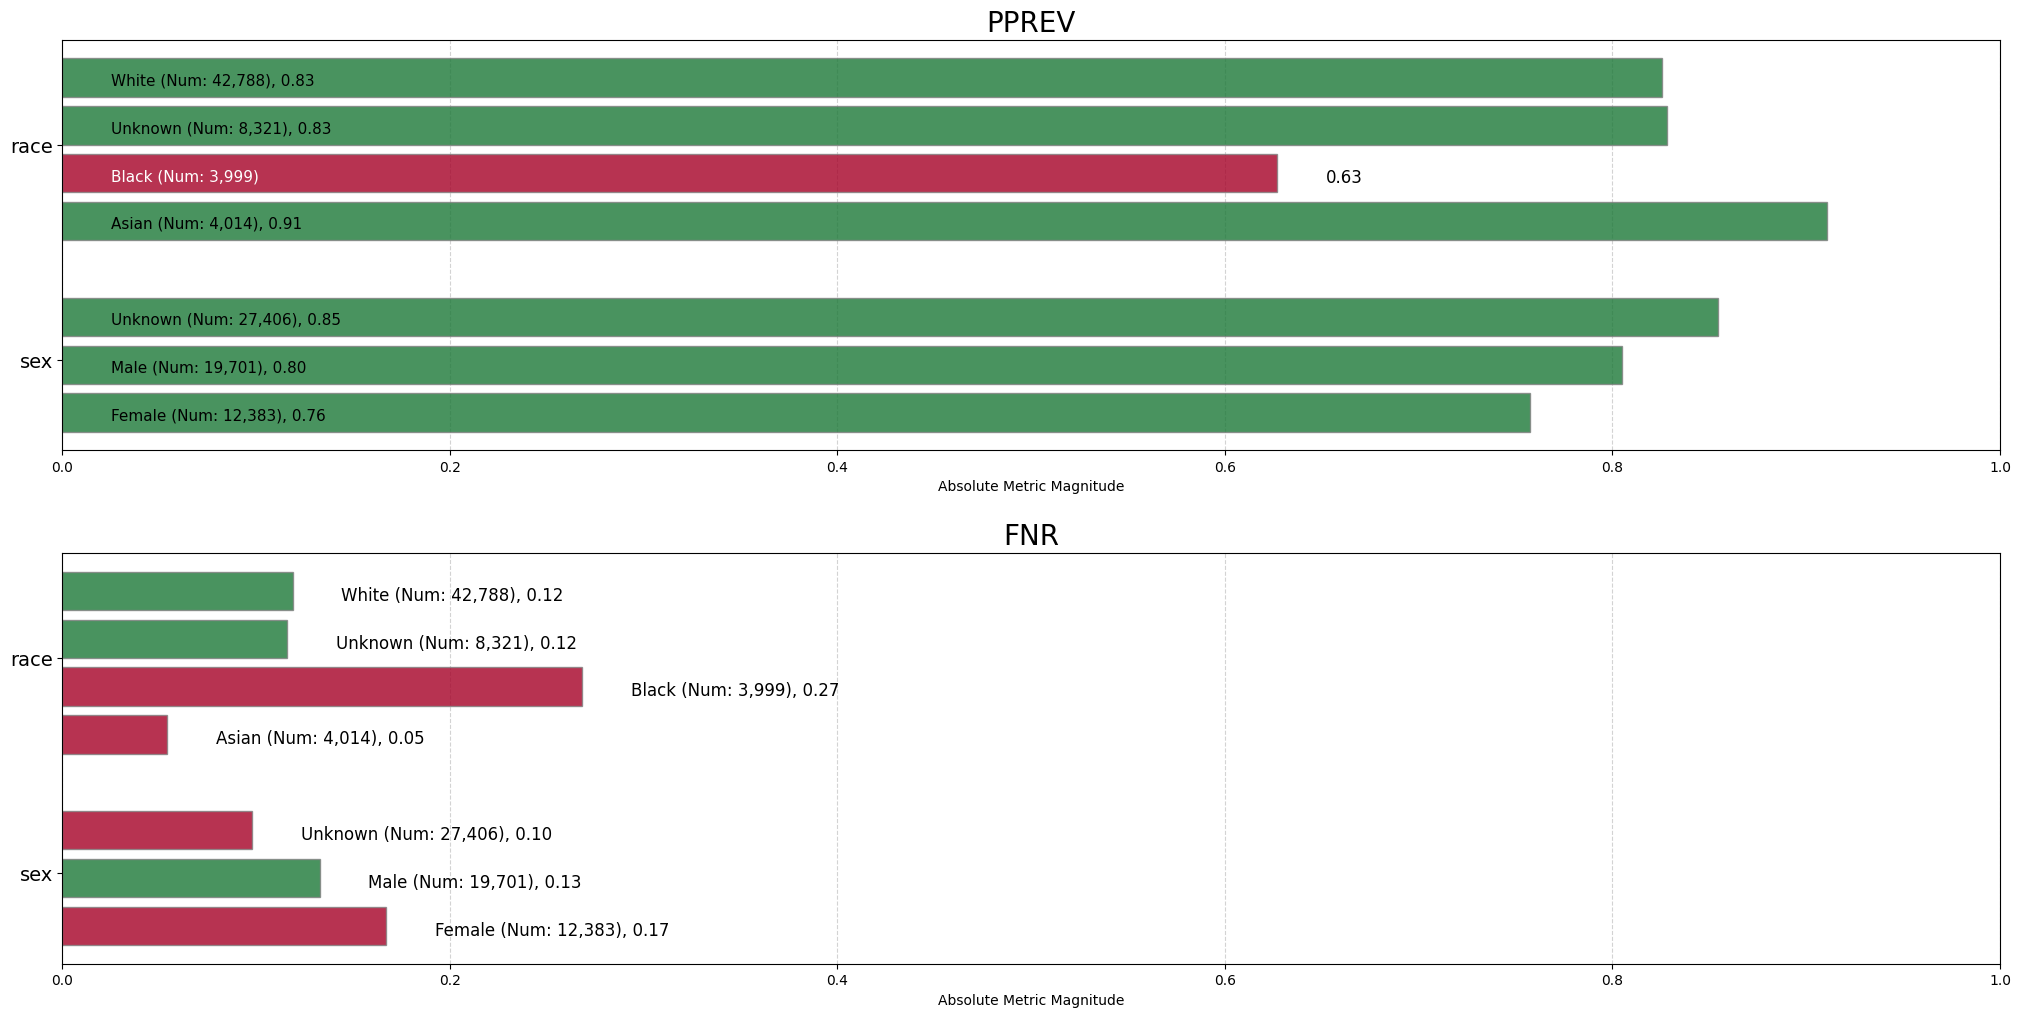

<Figure size 640x480 with 0 Axes>

In [33]:
fairness_report_tau_80 = aeq_fairness.get_group_value_fairness(
    bias_df=bias_report,
    tau=0.80,
)
_ = aeq_plot.plot_fairness_group_all(
    fairness_table=fairness_report_tau_80,
    ncols=1,
    metrics=['pprev', 'fnr'],
    min_group_size=0.01,
)

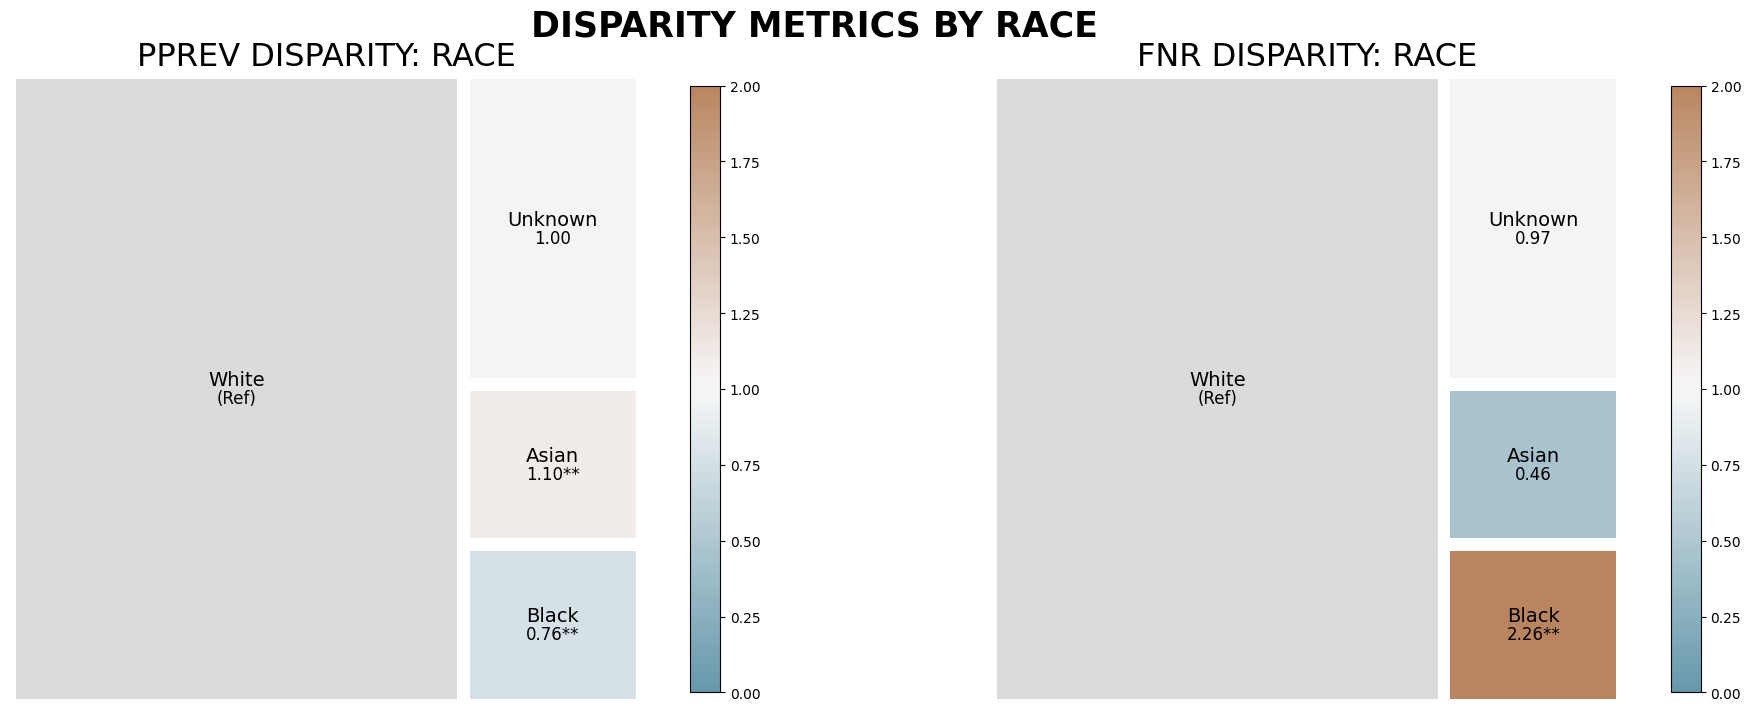

In [34]:
_ = aeq_plot.plot_disparity_all(
    data_table=fairness_report_tau_80,
    attributes=['race'],
    metrics=['pprev', 'fnr'],
    min_group_size=0.01,
    significance_alpha=0.05,
)

In [35]:
ap.disparity(
    disparity_df=bias_report,
    metrics_list=['pprev', 'fnr'],
    attribute='race',
    fairness_threshold=5/4,
)

alt.LayerChart(...)

### Measuring Group Fairness with AI Fairness 360


#### Preparing Data for use in AIF 360

In [36]:
aif_valid = valid.loc[(valid['black'] + valid['white'] == 1), :]
aif_valid = aif_valid.set_index(keys=['white'], append=True, drop=False)

In [44]:
aif_adverse_impact_ratio = aif_metrics.disparate_impact_ratio(
    aif_valid['Low Priced Offer'],
    prot_attr=['white'],
)
print(f"Adverse Impact Ratio (AIR): {aif_adverse_impact_ratio:0.3%}")

Adverse Impact Ratio (AIR): 75.927%


In [41]:
aif_fnr = aif_metrics.ratio(
    aif_metrics.false_negative_rate_error,
    aif_valid['low_priced'],
    aif_valid['Low Priced Offer'],
    prot_attr='white',
)
print(
    f"False Negative Rate Ratio: {aif_fnr:0.3f}"
)

False Negative Rate Ratio: 2.255


In [39]:
relative_auc_ratio = aif_metrics.ratio(
    sklearn_metrics.roc_auc_score,
    aif_valid['low_priced'],
    aif_valid['predictions'],
    prot_attr='white',
)
print(f"Relative ROC-AUC Scores for Blacks and Whites: {relative_auc_ratio:0.3f}")

Relative ROC-AUC Scores for Blacks and Whites: 0.938
